# 3.6 softmax回归的从零开始实现

In [1]:
import torch
import torchvision
import numpy as np
import sys
import torchvision.transforms as transforms

print(torch.__version__)
print(torchvision.__version__)

1.4.0
0.5.0


## 3.6.1 获取和读取数据

In [4]:

mnist_train = torchvision.datasets.FashionMNIST(root='E:/代码/算法/LinearRegression/pytorch/Datasets/FashionMNIST',
                                                train=True, 
                                                download=True,
                                                transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='E:/代码/算法/LinearRegression/pytorch/Datasets/FashionMNIST', 
                                               train=False, 
                                               download=True, 
                                               transform=transforms.ToTensor())
batch_size = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=1)

## 3.6.2 初始化模型参数

In [5]:
num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

In [6]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [7]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


## 3.6.3 实现softmax运算

In [8]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [9]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.1684, 0.1650, 0.2616, 0.2014, 0.2037],
        [0.1551, 0.2318, 0.2877, 0.1563, 0.1692]]) tensor([1.0000, 1.0000])


## 3.6.4 定义模型

In [10]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

## 3.6.5 定义损失函数

In [11]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [12]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

## 3.6.6 计算分类准确率

In [13]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [14]:
print(accuracy(y_hat, y))

0.5


In [15]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [16]:
print(evaluate_accuracy(test_iter, net))

0.1211


## 3.6.7 训练模型

In [18]:
num_epochs, lr = 5, 0.1

def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到
            
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7854, train acc 0.750, test acc 0.791
epoch 2, loss 0.5697, train acc 0.813, test acc 0.810
epoch 3, loss 0.5251, train acc 0.826, test acc 0.819
epoch 4, loss 0.5010, train acc 0.832, test acc 0.826
epoch 5, loss 0.4855, train acc 0.837, test acc 0.829


## 3.6.8 预测

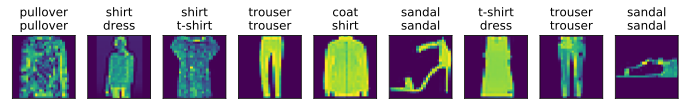

In [24]:
X, y = iter(test_iter).next()
from IPython import display
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
def use_svg_display():
    # 矢量图
    display.set_matplotlib_formats('svg')


def set_figure_size(figure_size=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figure_size
    
    
def show_fashion_mnist(images, labels):
    use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()
%matplotlib inline
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])